In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, RepeatVector
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import LearningRateScheduler
import keras.backend as K
import pandas as pd
import quandl
import numpy as np
from datetime import date
import math
from keras.callbacks import ReduceLROnPlateau

F:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df=pd.read_csv('data/0728 200user.csv')
df.head()

,p_norm,p_flex,ls,tariff,ls_move
0,296.10,303.90,1,0.288,0.0
1,274.66,325.34,1,0.288,1.0
2,311.65,288.35,1,0.288,1.0
3,314.81,285.19,1,0.288,1.0
4,304.68,0.00,1,0.288,1.0


In [4]:
train=df[['ls_move','p_norm','tariff','p_flex']][:96*243-96*2]

In [7]:
# time_stamp=96
# #生成训练集
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data=scaler.fit_transform(train)
# x_train,y_train=[],[]
# for i in range(241-1):
#     x_train.append(scaled_data[i*time_stamp:(i+1)*time_stamp,:3])
#     y_train.append(scaled_data[(i+1)*time_stamp:(i+2)*time_stamp, 3])
# x_train, y_train = np.array(x_train), np.array(y_train)
# y_train=y_train.reshape(-1,time_stamp,1)
# sp=int(0.9*len(x_train))
# x_train,x_test,y_train,y_test=x_train[0:sp],x_train[sp:],y_train[0:sp],y_train[sp:]
# print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(216, 96, 3) (24, 96, 3) (216, 96, 1) (24, 96, 1)


In [ ]:
data_input = np.load('data/input_features.npy')
data_output = np.load('data/p_flex.npy')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(data_input)
scaled_output = scaler.fit_transform(data_output)

time_stamp = 96
scaled_train_in = scaled_input[:243*96-96*31]
scaled_train_out = scaled_output[:243*96-96*31]
scaled_test_in = scaled_input[243*96-96*31:]
scaled_test_out = scaled_output[243*96-96*31:]

x_train, y_train=[], []
for i in range(241-31):
    x_train.append(scaled_train_in[i*time_stamp:(i+1)*time_stamp,:3])
    y_train.append(scaled_train_out[(i+1)*time_stamp:(i+2)*time_stamp, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = y_train.reshape(-1, time_stamp, 1)
sp = int(0.9*len(x_train))
x_train, x_valid, y_train, y_valid = x_train[0:sp], x_train[sp:], y_train[0:sp], y_train[sp:]
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

In [8]:
def scheduler(epoch):
    # 每隔100个epoch，学习率减小为原来的1/10
    if epoch % 500 == 0 and epoch != 0:
        lr = K.get_value(model1.optimizer.lr)
        K.set_value(model1.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model1.optimizer.lr)
  

In [10]:
#训练模型
epochs =2000
batch_size =324
callback = EarlyStopping(monitor='val_mean_squared_error', patience=16)
reduce_lr = LearningRateScheduler(scheduler)
model1 = Sequential()
model1.add(GRU(units=50,return_sequences=True,input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model1.add(GRU(units=50,return_sequences=True))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam',metrics=["mean_squared_error"])
history=model1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test,y_test),shuffle=False,callbacks=[reduce_lr])
score,_=model1.evaluate(x_test, y_test, batch_size=batch_size)
rmse=math.sqrt(score)
print("MSE:{:.3f},RMSE:{:.3f}".format(score,rmse))
model1.summary()

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
F:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=50, return_sequences=True, input_shape=(96, 3))`
  import sys


Train on 216 samples, validate on 24 samples
Epoch 1/2000
216/216 [==============================] - 2s 8ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 2/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 3/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 4/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 5/2000
216/216 [==============================] - 1s 3ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 6/2000
216/216 [==============================] - 1s 3ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0285 - va

Epoch 51/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 52/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 53/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 54/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 55/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 56/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 57/2

Epoch 101/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 102/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 103/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 104/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 105/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 106/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoc

Epoch 151/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 152/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 153/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 154/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 155/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 156/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoc

Epoch 201/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 202/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 203/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 204/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 205/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 206/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoc

Epoch 251/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 252/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 253/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 254/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 255/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 256/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoc

Epoch 301/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 302/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 303/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 304/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 305/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 306/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoc

Epoch 351/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 352/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 353/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 354/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 355/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 356/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoc

Epoch 401/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 402/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 403/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 404/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 405/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 406/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoc

Epoch 451/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 452/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 453/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 454/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 455/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 456/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoc

Epoch 501/2000
lr changed to 0.00010000000474974513
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 502/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 503/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 504/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 505/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 506/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0039 

Epoch 551/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 552/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 553/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 554/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 555/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 556/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoc

Epoch 601/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 602/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 603/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 604/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 605/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 606/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoc

Epoch 651/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 652/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 653/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 654/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 655/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 656/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoc

Epoch 701/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 702/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 703/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 704/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 705/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 706/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoc

Epoch 751/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 752/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 753/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 754/2000
216/216 [==============================] - 1s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 755/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 756/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoc

Epoch 801/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 802/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 803/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 804/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 805/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 806/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoc

Epoch 851/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 852/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 853/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 854/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 855/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 856/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoc

Epoch 901/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 902/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 903/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 904/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 905/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 906/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoc

Epoch 951/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 952/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 953/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 954/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 955/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 956/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoc

Epoch 1001/2000
lr changed to 1.0000000474974514e-05
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1002/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1003/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1004/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1005/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1006/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0

Epoch 1050/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1051/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1052/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1053/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1054/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1055/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.002

216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1100/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1101/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1102/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1103/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1104/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1105/200

Epoch 1149/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1150/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1151/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1152/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1153/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1154/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.002

216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1199/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1200/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1201/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1202/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1203/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1204/200

Epoch 1248/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1249/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1250/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1251/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1252/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1253/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.002

216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1298/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1299/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1300/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1301/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1302/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1303/200

Epoch 1347/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1348/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1349/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1350/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1351/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1352/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.002

216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1397/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1398/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1399/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1400/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1401/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1402/200

Epoch 1446/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1447/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1448/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1449/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1450/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1451/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.001

216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1496/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1497/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1498/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1499/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1500/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1501/200

Epoch 1544/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1545/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1546/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1547/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1548/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1549/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.001

216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1594/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1595/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1596/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1597/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1598/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1599/200

Epoch 1643/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1644/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1645/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1646/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1647/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1648/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.001

216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1693/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1694/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1695/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1696/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1697/2000
216/216 [==============================] - 1s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1698/200

Epoch 1742/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1743/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1744/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1745/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1746/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1747/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.001

216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1792/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1793/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1794/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1795/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1796/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1797/200

Epoch 1841/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1842/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1843/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1844/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1845/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1846/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.001

216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1891/2000
216/216 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1892/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1893/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1894/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1895/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1896/200

Epoch 1940/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1941/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1942/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1943/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1944/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1945/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.001

216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1990/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1991/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1992/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1993/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1994/2000
216/216 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1995/200

In [11]:
model1.save('0730 GRU.h5')

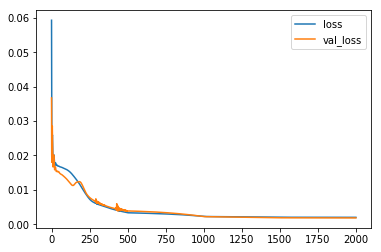

In [12]:
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()